Implementing AutoRec, Deep AutoEncoders for CF (improvement over AutoRec) (approved by sir)

# MODEL

In [1]:
! pip install tensorflow

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
# from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, merge, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import initializers
from tensorflow.keras.layers import add, concatenate
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow.python.keras.models import model_from_json
from sklearn import preprocessing
from keras.utils import plot_model

In [2]:
def dataPreprocessor(rating_df, num_users, num_items, init_value=0, average=False):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
    """
    if average:
      matrix = np.full((num_users, num_items), 0.0)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating
      avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
      inds = np.where(matrix == 0)
      matrix[inds] = np.take(avergae, inds[0])
      
    else:
      matrix = np.full((num_users, num_items), init_value)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating

    return matrix

In [3]:
def show_error(history, skip):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(np.arange(skip, len(loss), 1), loss[skip:])
    plt.plot(np.arange(skip, len(loss), 1), val_loss[skip:])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()
     

def show_rmse(history, skip):
    rmse = history.history['masked_rmse_clip']
    val_rmse = history.history['val_masked_rmse_clip']
    plt.plot(np.arange(skip, len(rmse), 1), rmse[skip:])
    plt.plot(np.arange(skip, len(val_rmse), 1), val_rmse[skip:])
    plt.title('model train vs validation masked_rmse')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()
     
def masked_se(y_true, y_pred):
        print(type(y_true),' ',type(y_pred))
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1)
        return masked_mse
def masked_se_clip_10(y_true, y_pred):
        print(type(y_true),' ',type(y_pred))
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 10)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1)
        return masked_mse     

def masked_mse(y_true, y_pred):
        # masked function
        y_true = tf.cast(y_true, tf.float32)
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse
     

def masked_rmse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse
     

def masked_rmse_clip(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 5)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

def masked_mse_clip_10(y_true, y_pred):
        # masked function
        y_true = tf.cast(y_true, tf.float32)
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 10)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse
def masked_rmse_clip_10(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 10)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

##AutoRec

In [4]:
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, Activation, BatchNormalization, LeakyReLU

In [5]:
def AutoRec(X, reg, first_activation, last_activation):
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    x = Dense(500, activation=first_activation, name='LatentSpace', kernel_regularizer=regularizers.l2(reg))(x)
    output_layer = Dense(X.shape[1], activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(reg))(x)
    model = Model(input_layer, output_layer)

    return model

## books dataset

In [6]:
datContent = [i.strip().split() for i in open("book_ratings.dat").readlines()][1:]

In [7]:
max_user=0
max_book=0
for r in datContent:
  # print(r)
  max_user=max(max_user,int(r[0]))
  max_book=max(max_book,int(r[1]))
print(max_book,max_user)

17384 2945


## U-AutoRec

In [8]:
def my_proc(cont,init_val):
  matrix = np.full((max_user,max_book),init_val)
  for r in cont:
    matrix[int(r[0])-1, int(r[1])-1] = float(r[2])
  return matrix

def my_proc_avg(cont): 
  matrix = np.full((max_user,max_book),0)
  for r in cont:
    matrix[int(r[0])-1, int(r[1])-1] = float(r[2])
  avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
  inds = np.where(matrix == 0)
  matrix[inds] = np.take(avergae, inds[0])
  return matrix

In [10]:
train_df, test_df = train_test_split(datContent,test_size=0.1,random_state=999613182)  
train_df, validate_df = train_test_split(train_df,test_size=0.1,random_state=999613182) 

In [11]:
print(len(train_df),len(test_df),len(validate_df))

50751 6266 5639


In [23]:
len(datContent)

62656

In [9]:
import numpy as np
from sklearn.model_selection import KFold

X = ["a", "b", "c", "d","e","a", "b", "c", "d","e"]
kf = KFold(n_splits=5,shuffle=True,random_state=999613182)
for train, test in kf.split(X):
  print(train,test)
  # kf2 = KFold(n_splits=2)
  # for val , test2 in kf2.split(test):
  #   print(train,' ',val,' ',test2)

[0 1 2 3 4 6 7 8] [5 9]
[0 1 2 3 4 5 6 9] [7 8]
[0 1 2 4 5 7 8 9] [3 6]
[1 3 4 5 6 7 8 9] [0 2]
[0 2 3 5 6 7 8 9] [1 4]


In [10]:
kf = KFold(n_splits=5,shuffle=True,random_state=999613182)
folds=[] #train validate, test
for train_idx, rem_idx in kf.split(datContent):
  train=[]
  validate=[]
  test=[]
  n = len(rem_idx)//2
  valid_idx=rem_idx[0:n]
  test_idx=rem_idx[n:]
  for i in train_idx:
    train.append(datContent[i])
  for i in valid_idx:
    validate.append(datContent[i])
  for i in test_idx:
    test.append(datContent[i])
  fold=[train,validate,test]
  print(len(fold[0]),len(fold[1]),len(fold[2]))
  folds.append(fold)

50124 6266 6266
50125 6265 6266
50125 6265 6266
50125 6265 6266
50125 6265 6266


In [ ]:
init_v = 0
users_items_matrix_train_zero = my_proc(train_df,init_v)
users_items_matrix_train_avg = my_proc_avg(train_df)
users_items_matrix_validate = my_proc(validate_df,init_v)
users_items_matrix_test = my_proc(test_df,init_v)

In [ ]:
users_items_matrix_train_zero.shape

(2945, 17384)

In [ ]:
model = AutoRec(users_items_matrix_train_zero, 0.0005, 'elu', 'elu')

model.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_mse_clip_10, masked_rmse_clip_10,masked_se_clip_10])
 
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 17384)]           0         
                                                                 
 LatentSpace (Dense)         (None, 500)               8692500   
                                                                 
 UserScorePred (Dense)       (None, 17384)             8709384   
                                                                 
Total params: 17,401,884
Trainable params: 17,401,884
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Autorec = model.fit(x=users_items_matrix_train_avg, y=users_items_matrix_train_zero,
                  epochs=100,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_avg, users_items_matrix_validate])

In [ ]:
test_result = model.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
print(test_result)

93/93 [==============================] - 3s 31ms/step - loss: 3.8000 - masked_mse_clip_10: 3.0306 - masked_rmse_clip_10: 0.9538 - masked_se_clip_10: 14.8020
[3.8000221252441406, 3.0306003093719482, 0.9538436532020569, 14.80201244354248]


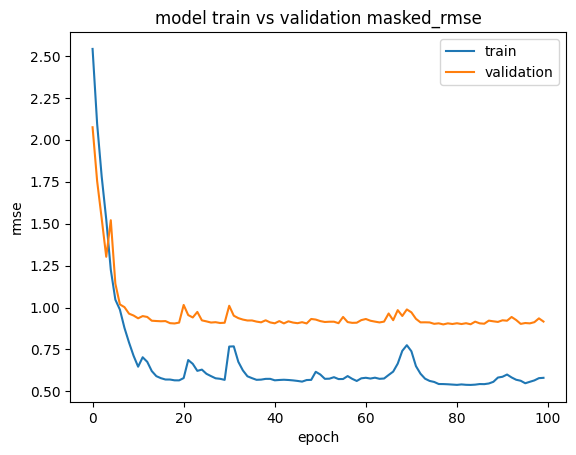

In [ ]:
rmse = hist_Autorec.history['masked_rmse_clip_10']
val_rmse = hist_Autorec.history['val_masked_rmse_clip_10']
plt.plot(np.arange(0, len(rmse), 1), rmse[0:])
plt.plot(np.arange(0, len(val_rmse), 1), val_rmse[0:])
plt.title('model train vs validation masked_rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

#Tuning hyperparameters

In [ ]:
import gc

In [ ]:
gc.collect()

0

In [ ]:
activations=['linear','sigmoid','relu']
for outer_activation in activations:
  for inner_activation in activations:
    gc.collect()
    model = AutoRec(users_items_matrix_train_zero, 0.0005, outer_activation,inner_activation)
    model.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_mse_clip_10, masked_rmse_clip_10])
    hist_Autorec = model.fit(x=users_items_matrix_train_avg, y=users_items_matrix_train_zero,
                  epochs=50,
                  batch_size=256,
                  verbose = 1, 
                  validation_data=[users_items_matrix_train_avg, users_items_matrix_validate])
    test_result = model.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
    print("first: ", outer_activation,"sec: ",inner_activation)
    print(test_result)
    gc.collect()

Epoch 1/50
12/12 [==============================] - 19s 1s/step - loss: 165.0847 - masked_mse_clip_10: 13.6260 - masked_rmse_clip_10: 2.4164 - val_loss: 62.2668 - val_masked_mse_clip_10: 12.2675 - val_masked_rmse_clip_10: 2.1264
Epoch 2/50
12/12 [==============================] - 14s 1s/step - loss: 55.1606 - masked_mse_clip_10: 11.0886 - masked_rmse_clip_10: 2.1769 - val_loss: 39.3904 - val_masked_mse_clip_10: 10.2004 - val_masked_rmse_clip_10: 1.9127
Epoch 3/50
12/12 [==============================] - 15s 1s/step - loss: 28.2697 - masked_mse_clip_10: 9.1372 - masked_rmse_clip_10: 1.9719 - val_loss: 18.0534 - val_masked_mse_clip_10: 9.6003 - val_masked_rmse_clip_10: 1.8613
Epoch 4/50
12/12 [==============================] - 15s 1s/step - loss: 15.5035 - masked_mse_clip_10: 7.2071 - masked_rmse_clip_10: 1.7445 - val_loss: 14.8261 - val_masked_mse_clip_10: 8.9235 - val_masked_rmse_clip_10: 1.7750
Epoch 5/50
12/12 [==============================] - 16s 1s/step - loss: 10.2665 - masked_ms

Epoch 1/50
12/12 [==============================] - 17s 1s/step - loss: 25.0732 - masked_mse_clip_10: 22.3416 - masked_rmse_clip_10: 3.1125 - val_loss: 22.8022 - val_masked_mse_clip_10: 20.8502 - val_masked_rmse_clip_10: 2.8866
Epoch 2/50
12/12 [==============================] - 14s 1s/step - loss: 23.8542 - masked_mse_clip_10: 22.3416 - masked_rmse_clip_10: 3.1125 - val_loss: 22.1636 - val_masked_mse_clip_10: 20.8502 - val_masked_rmse_clip_10: 2.8866
Epoch 3/50
12/12 [==============================] - 14s 1s/step - loss: 23.4326 - masked_mse_clip_10: 22.3416 - masked_rmse_clip_10: 3.1125 - val_loss: 22.0622 - val_masked_mse_clip_10: 20.8502 - val_masked_rmse_clip_10: 2.8866
Epoch 4/50
12/12 [==============================] - 13s 1s/step - loss: 23.3662 - masked_mse_clip_10: 22.3416 - masked_rmse_clip_10: 3.1125 - val_loss: 21.9546 - val_masked_mse_clip_10: 20.8502 - val_masked_rmse_clip_10: 2.8866
Epoch 5/50
12/12 [==============================] - 14s 1s/step - loss: 23.2405 - masked

Epoch 1/50
12/12 [==============================] - 15s 1s/step - loss: 106.9711 - masked_mse_clip_10: 16.4493 - masked_rmse_clip_10: 2.6652 - val_loss: 65.5163 - val_masked_mse_clip_10: 16.2020 - val_masked_rmse_clip_10: 2.4988
Epoch 2/50
12/12 [==============================] - 15s 1s/step - loss: 56.2676 - masked_mse_clip_10: 18.3256 - masked_rmse_clip_10: 2.8164 - val_loss: 37.4344 - val_masked_mse_clip_10: 18.1026 - val_masked_rmse_clip_10: 2.6657
Epoch 3/50
12/12 [==============================] - 13s 1s/step - loss: 38.1565 - masked_mse_clip_10: 18.1296 - masked_rmse_clip_10: 2.8024 - val_loss: 37.9593 - val_masked_mse_clip_10: 15.3422 - val_masked_rmse_clip_10: 2.4251
Epoch 4/50
12/12 [==============================] - 14s 1s/step - loss: 32.7202 - masked_mse_clip_10: 17.1560 - masked_rmse_clip_10: 2.7248 - val_loss: 29.4199 - val_masked_mse_clip_10: 14.4931 - val_masked_rmse_clip_10: 2.3397
Epoch 5/50
12/12 [==============================] - 15s 1s/step - loss: 24.8587 - maske

Epoch 1/50
12/12 [==============================] - 17s 1s/step - loss: 25.5780 - masked_mse_clip_10: 21.5841 - masked_rmse_clip_10: 3.0581 - val_loss: 18.9402 - val_masked_mse_clip_10: 17.5671 - val_masked_rmse_clip_10: 2.6398
Epoch 2/50
12/12 [==============================] - 16s 1s/step - loss: 15.3778 - masked_mse_clip_10: 14.8403 - masked_rmse_clip_10: 2.5201 - val_loss: 11.7565 - val_masked_mse_clip_10: 10.7667 - val_masked_rmse_clip_10: 2.0209
Epoch 3/50
12/12 [==============================] - 14s 1s/step - loss: 8.2188 - masked_mse_clip_10: 7.6793 - masked_rmse_clip_10: 1.7936 - val_loss: 7.4595 - val_masked_mse_clip_10: 6.3081 - val_masked_rmse_clip_10: 1.4813
Epoch 4/50
12/12 [==============================] - 14s 1s/step - loss: 4.5663 - masked_mse_clip_10: 3.8474 - masked_rmse_clip_10: 1.2638 - val_loss: 5.7943 - val_masked_mse_clip_10: 4.4491 - val_masked_rmse_clip_10: 1.2029
Epoch 5/50
12/12 [==============================] - 14s 1s/step - loss: 3.1033 - masked_mse_clip

Epoch 1/50
12/12 [==============================] - 17s 1s/step - loss: 25.2623 - masked_mse_clip_10: 22.3416 - masked_rmse_clip_10: 3.1125 - val_loss: 22.4748 - val_masked_mse_clip_10: 20.8502 - val_masked_rmse_clip_10: 2.8866
Epoch 2/50
12/12 [==============================] - 14s 1s/step - loss: 23.4173 - masked_mse_clip_10: 22.3416 - masked_rmse_clip_10: 3.1125 - val_loss: 21.7856 - val_masked_mse_clip_10: 20.8502 - val_masked_rmse_clip_10: 2.8866
Epoch 3/50
12/12 [==============================] - 14s 1s/step - loss: 22.9449 - masked_mse_clip_10: 22.3416 - masked_rmse_clip_10: 3.1125 - val_loss: 21.6291 - val_masked_mse_clip_10: 20.8502 - val_masked_rmse_clip_10: 2.8866
Epoch 4/50
12/12 [==============================] - 14s 1s/step - loss: 22.8338 - masked_mse_clip_10: 22.3416 - masked_rmse_clip_10: 3.1125 - val_loss: 21.5900 - val_masked_mse_clip_10: 20.8502 - val_masked_rmse_clip_10: 2.8866
Epoch 5/50
12/12 [==============================] - 14s 1s/step - loss: 22.7995 - masked

Epoch 1/50
12/12 [==============================] - 18s 1s/step - loss: 26.2753 - masked_mse_clip_10: 21.3596 - masked_rmse_clip_10: 3.0417 - val_loss: 21.0837 - val_masked_mse_clip_10: 17.7191 - val_masked_rmse_clip_10: 2.6478
Epoch 2/50
12/12 [==============================] - 14s 1s/step - loss: 18.7423 - masked_mse_clip_10: 16.1104 - masked_rmse_clip_10: 2.6312 - val_loss: 14.7340 - val_masked_mse_clip_10: 12.8798 - val_masked_rmse_clip_10: 2.2104
Epoch 3/50
12/12 [==============================] - 15s 1s/step - loss: 10.9603 - masked_mse_clip_10: 9.9014 - masked_rmse_clip_10: 2.0487 - val_loss: 8.6326 - val_masked_mse_clip_10: 7.4654 - val_masked_rmse_clip_10: 1.6215
Epoch 4/50
12/12 [==============================] - 14s 1s/step - loss: 5.2659 - masked_mse_clip_10: 4.5855 - masked_rmse_clip_10: 1.3820 - val_loss: 6.1536 - val_masked_mse_clip_10: 4.9010 - val_masked_rmse_clip_10: 1.2743
Epoch 5/50
12/12 [==============================] - 15s 1s/step - loss: 3.2691 - masked_mse_cli

Epoch 1/50
12/12 [==============================] - 15s 1s/step - loss: 34.3341 - masked_mse_clip_10: 18.9814 - masked_rmse_clip_10: 2.8516 - val_loss: 17.3498 - val_masked_mse_clip_10: 10.3055 - val_masked_rmse_clip_10: 1.9279
Epoch 2/50
12/12 [==============================] - 16s 1s/step - loss: 7.9417 - masked_mse_clip_10: 5.5413 - masked_rmse_clip_10: 1.5045 - val_loss: 4.8746 - val_masked_mse_clip_10: 3.6530 - val_masked_rmse_clip_10: 1.0555
Epoch 3/50
12/12 [==============================] - 14s 1s/step - loss: 2.2296 - masked_mse_clip_10: 1.6454 - masked_rmse_clip_10: 0.8335 - val_loss: 4.1173 - val_masked_mse_clip_10: 3.0475 - val_masked_rmse_clip_10: 0.9432
Epoch 4/50
12/12 [==============================] - 16s 1s/step - loss: 1.5102 - masked_mse_clip_10: 1.0095 - masked_rmse_clip_10: 0.6496 - val_loss: 4.0007 - val_masked_mse_clip_10: 2.9309 - val_masked_rmse_clip_10: 0.9118
Epoch 5/50
12/12 [==============================] - 16s 1s/step - loss: 1.3788 - masked_mse_clip_10:

Epoch 1/50
12/12 [==============================] - 18s 1s/step - loss: 24.4995 - masked_mse_clip_10: 22.3416 - masked_rmse_clip_10: 3.1125 - val_loss: 22.0706 - val_masked_mse_clip_10: 20.8502 - val_masked_rmse_clip_10: 2.8866
Epoch 2/50
12/12 [==============================] - 16s 1s/step - loss: 23.1579 - masked_mse_clip_10: 22.3416 - masked_rmse_clip_10: 3.1125 - val_loss: 21.5759 - val_masked_mse_clip_10: 20.8502 - val_masked_rmse_clip_10: 2.8866
Epoch 3/50
12/12 [==============================] - 15s 1s/step - loss: 22.7715 - masked_mse_clip_10: 22.3416 - masked_rmse_clip_10: 3.1125 - val_loss: 21.5258 - val_masked_mse_clip_10: 20.8502 - val_masked_rmse_clip_10: 2.8866
Epoch 4/50
12/12 [==============================] - 14s 1s/step - loss: 22.7191 - masked_mse_clip_10: 22.3416 - masked_rmse_clip_10: 3.1125 - val_loss: 21.4176 - val_masked_mse_clip_10: 20.8502 - val_masked_rmse_clip_10: 2.8866
Epoch 5/50
12/12 [==============================] - 14s 1s/step - loss: 22.6603 - masked

Epoch 1/50
12/12 [==============================] - 16s 1s/step - loss: 35.6619 - masked_mse_clip_10: 15.6020 - masked_rmse_clip_10: 2.5871 - val_loss: 15.4590 - val_masked_mse_clip_10: 11.6756 - val_masked_rmse_clip_10: 2.0688
Epoch 2/50
12/12 [==============================] - 16s 1s/step - loss: 12.7464 - masked_mse_clip_10: 9.9293 - masked_rmse_clip_10: 2.0633 - val_loss: 10.1628 - val_masked_mse_clip_10: 7.9234 - val_masked_rmse_clip_10: 1.6332
Epoch 3/50
12/12 [==============================] - 16s 1s/step - loss: 7.2966 - masked_mse_clip_10: 5.6403 - masked_rmse_clip_10: 1.5470 - val_loss: 7.6018 - val_masked_mse_clip_10: 5.8973 - val_masked_rmse_clip_10: 1.3610
Epoch 4/50
12/12 [==============================] - 15s 1s/step - loss: 5.5352 - masked_mse_clip_10: 4.1423 - masked_rmse_clip_10: 1.3156 - val_loss: 7.2718 - val_masked_mse_clip_10: 5.5968 - val_masked_rmse_clip_10: 1.3190
Epoch 5/50
12/12 [==============================] - 18s 2s/step - loss: 5.0854 - masked_mse_clip_1

#Fold Validation

In [12]:
import gc
init_v = 0

In [13]:
f=0
for fold in folds:
  f+=1
  gc.collect()
  users_items_matrix_train_zero = my_proc(fold[0],init_v)
  users_items_matrix_train_avg = my_proc_avg(fold[0])
  users_items_matrix_validate = my_proc(fold[1],init_v)
  users_items_matrix_test = my_proc(fold[2],init_v)
  model = AutoRec(users_items_matrix_train_zero, 0.0005, 'relu','linear')
  model.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_mse_clip_10, masked_rmse_clip_10])
  hist_Autorec = model.fit(x=users_items_matrix_train_avg, y=users_items_matrix_train_zero,
                epochs=50,
                batch_size=256,
                verbose = 1, 
                validation_data=[users_items_matrix_train_avg, users_items_matrix_validate])
  test_result = model.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
  print("Fold no: ",f,test_result)


Epoch 1/50
12/12 [==============================] - 17s 1s/step - loss: 32.2815 - masked_mse_clip_10: 17.6654 - masked_rmse_clip_10: 2.7458 - val_loss: 8.2180 - val_masked_mse_clip_10: 5.0998 - val_masked_rmse_clip_10: 1.0181
Epoch 2/50
12/12 [==============================] - 16s 1s/step - loss: 7.1591 - masked_mse_clip_10: 5.1722 - masked_rmse_clip_10: 1.4544 - val_loss: 2.7533 - val_masked_mse_clip_10: 1.9243 - val_masked_rmse_clip_10: 0.5944
Epoch 3/50
12/12 [==============================] - 13s 1s/step - loss: 2.1598 - masked_mse_clip_10: 1.6104 - masked_rmse_clip_10: 0.8231 - val_loss: 2.3155 - val_masked_mse_clip_10: 1.6029 - val_masked_rmse_clip_10: 0.5331
Epoch 4/50
12/12 [==============================] - 14s 1s/step - loss: 1.4680 - masked_mse_clip_10: 1.0036 - masked_rmse_clip_10: 0.6477 - val_loss: 2.2855 - val_masked_mse_clip_10: 1.5575 - val_masked_rmse_clip_10: 0.5223
Epoch 5/50
12/12 [==============================] - 12s 981ms/step - loss: 1.2934 - masked_mse_clip_10

Epoch 1/50
12/12 [==============================] - 17s 1s/step - loss: 31.5349 - masked_mse_clip_10: 18.0518 - masked_rmse_clip_10: 2.7789 - val_loss: 8.8593 - val_masked_mse_clip_10: 5.3615 - val_masked_rmse_clip_10: 1.0433
Epoch 2/50
12/12 [==============================] - 14s 1s/step - loss: 7.6639 - masked_mse_clip_10: 5.4336 - masked_rmse_clip_10: 1.4893 - val_loss: 2.7410 - val_masked_mse_clip_10: 1.9242 - val_masked_rmse_clip_10: 0.5951
Epoch 3/50
12/12 [==============================] - 13s 1s/step - loss: 2.1662 - masked_mse_clip_10: 1.6269 - masked_rmse_clip_10: 0.8283 - val_loss: 2.3078 - val_masked_mse_clip_10: 1.6004 - val_masked_rmse_clip_10: 0.5351
Epoch 4/50
12/12 [==============================] - 12s 1s/step - loss: 1.4472 - masked_mse_clip_10: 0.9891 - masked_rmse_clip_10: 0.6423 - val_loss: 2.1960 - val_masked_mse_clip_10: 1.4985 - val_masked_rmse_clip_10: 0.5120
Epoch 5/50
12/12 [==============================] - 13s 1s/step - loss: 1.2646 - masked_mse_clip_10: 0

Epoch 1/50
12/12 [==============================] - 15s 1s/step - loss: 32.3730 - masked_mse_clip_10: 18.0337 - masked_rmse_clip_10: 2.7798 - val_loss: 8.1252 - val_masked_mse_clip_10: 4.8304 - val_masked_rmse_clip_10: 0.9767
Epoch 2/50
12/12 [==============================] - 13s 1s/step - loss: 7.3076 - masked_mse_clip_10: 5.1231 - masked_rmse_clip_10: 1.4483 - val_loss: 2.7528 - val_masked_mse_clip_10: 1.9841 - val_masked_rmse_clip_10: 0.6049
Epoch 3/50
12/12 [==============================] - 13s 1s/step - loss: 2.2595 - masked_mse_clip_10: 1.6797 - masked_rmse_clip_10: 0.8399 - val_loss: 2.3377 - val_masked_mse_clip_10: 1.5555 - val_masked_rmse_clip_10: 0.5246
Epoch 4/50
12/12 [==============================] - 14s 1s/step - loss: 1.5490 - masked_mse_clip_10: 1.0550 - masked_rmse_clip_10: 0.6638 - val_loss: 2.2624 - val_masked_mse_clip_10: 1.5388 - val_masked_rmse_clip_10: 0.5225
Epoch 5/50
12/12 [==============================] - 14s 1s/step - loss: 1.3891 - masked_mse_clip_10: 0

Epoch 1/50
12/12 [==============================] - 15s 1s/step - loss: 34.0070 - masked_mse_clip_10: 18.3433 - masked_rmse_clip_10: 2.8008 - val_loss: 7.9512 - val_masked_mse_clip_10: 4.8276 - val_masked_rmse_clip_10: 0.9807
Epoch 2/50
12/12 [==============================] - 15s 1s/step - loss: 7.2243 - masked_mse_clip_10: 5.1873 - masked_rmse_clip_10: 1.4552 - val_loss: 2.5844 - val_masked_mse_clip_10: 1.7748 - val_masked_rmse_clip_10: 0.5669
Epoch 3/50
12/12 [==============================] - 15s 1s/step - loss: 2.1635 - masked_mse_clip_10: 1.5864 - masked_rmse_clip_10: 0.8175 - val_loss: 2.2925 - val_masked_mse_clip_10: 1.4622 - val_masked_rmse_clip_10: 0.5041
Epoch 4/50
12/12 [==============================] - 15s 1s/step - loss: 1.6379 - masked_mse_clip_10: 1.0857 - masked_rmse_clip_10: 0.6741 - val_loss: 2.1219 - val_masked_mse_clip_10: 1.3969 - val_masked_rmse_clip_10: 0.4921
Epoch 5/50
12/12 [==============================] - 15s 1s/step - loss: 1.3508 - masked_mse_clip_10: 0

Epoch 1/50
12/12 [==============================] - 15s 1s/step - loss: 32.6236 - masked_mse_clip_10: 18.2279 - masked_rmse_clip_10: 2.7911 - val_loss: 8.2592 - val_masked_mse_clip_10: 4.8976 - val_masked_rmse_clip_10: 0.9881
Epoch 2/50
12/12 [==============================] - 12s 1s/step - loss: 7.4041 - masked_mse_clip_10: 5.2939 - masked_rmse_clip_10: 1.4684 - val_loss: 2.6804 - val_masked_mse_clip_10: 1.8982 - val_masked_rmse_clip_10: 0.5949
Epoch 3/50
12/12 [==============================] - 13s 1s/step - loss: 2.2018 - masked_mse_clip_10: 1.6324 - masked_rmse_clip_10: 0.8281 - val_loss: 2.2211 - val_masked_mse_clip_10: 1.4968 - val_masked_rmse_clip_10: 0.5182
Epoch 4/50
12/12 [==============================] - 14s 1s/step - loss: 1.4778 - masked_mse_clip_10: 0.9890 - masked_rmse_clip_10: 0.6421 - val_loss: 2.1366 - val_masked_mse_clip_10: 1.4204 - val_masked_rmse_clip_10: 0.5002
Epoch 5/50
12/12 [==============================] - 14s 1s/step - loss: 1.3028 - masked_mse_clip_10: 0

# I-Autorec

In [14]:
def my_proc_2(cont):
  matrix = np.full((max_book,max_user),0)
  for r in cont:
    matrix[int(r[1])-1,int(r[0])-1] = float(r[2])
  return matrix

def my_proc_avg_2(cont): 
  matrix = np.full((max_book,max_user),0)
  for r in cont:
    matrix[int(r[1])-1,int(r[0])-1] = float(r[2])
  avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
  inds = np.where(matrix == 0)
  matrix[inds] = np.take(avergae, inds[0])
  return matrix

In [15]:
train_df, test_df = train_test_split(datContent,test_size=0.1,random_state=999613182)  
train_df, validate_df = train_test_split(train_df,test_size=0.1,random_state=999613182) 

In [16]:
print(len(train_df),len(test_df),len(validate_df))

50751 6266 5639


In [17]:
users_items_matrix_train_zero = my_proc_2(train_df)
users_items_matrix_train_avg = my_proc_avg_2(train_df)
users_items_matrix_validate = my_proc_2(validate_df)
users_items_matrix_test = my_proc_2(test_df)

In [18]:
users_items_matrix_train_zero.shape

(17384, 2945)

In [ ]:
model2 = AutoRec(users_items_matrix_train_zero, 0.0005, 'elu', 'elu')

model2.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_mse_clip_10, masked_rmse_clip_10,masked_se_clip_10])
 
model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 2945)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1473000   
                                                                 
 UserScorePred (Dense)       (None, 2945)              1475445   
                                                                 
Total params: 2,948,445
Trainable params: 2,948,445
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Autorec2 = model2.fit(x=users_items_matrix_train_avg, y=users_items_matrix_train_zero,
                  epochs=100,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_avg, users_items_matrix_validate])

Epoch 1/100
<class 'tensorflow.python.framework.ops.Tensor'>   <class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>   <class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>   <class 'tensorflow.python.framework.ops.Tensor'>
68/68 - 9s - loss: 22.3808 - masked_mse_clip_10: 12.0177 - masked_rmse_clip_10: 2.5676 - masked_se_clip_10: 44.5448 - val_loss: 5.0249 - val_masked_mse_clip_10: 3.3007 - val_masked_rmse_clip_10: 0.6617 - val_masked_se_clip_10: 4.1646 - 9s/epoch - 128ms/step
Epoch 2/100
68/68 - 7s - loss: 8.9249 - masked_mse_clip_10: 5.7535 - masked_rmse_clip_10: 1.5840 - masked_se_clip_10: 20.6244 - val_loss: 4.1209 - val_masked_mse_clip_10: 2.7471 - val_masked_rmse_clip_10: 0.5792 - val_masked_se_clip_10: 3.3618 - 7s/epoch - 103ms/step
Epoch 3/100
68/68 - 7s - loss: 6.7694 - masked_mse_clip_10: 4.4097 - masked_rmse_clip_10: 1.3509 - masked_se_clip_10: 15.6062 - val_loss: 3.8633 - val_masked_mse_

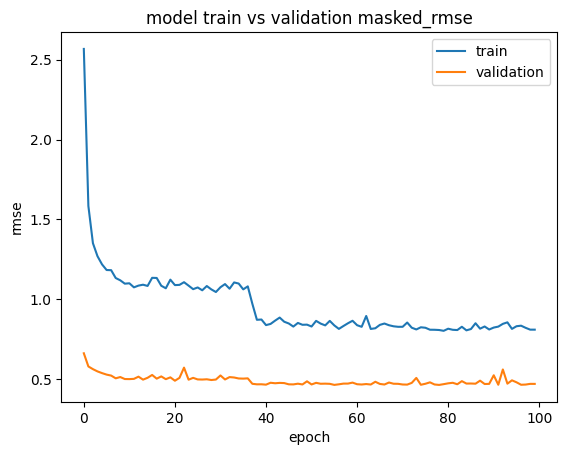

In [ ]:
rmse = hist_Autorec2.history['masked_rmse_clip_10']
val_rmse = hist_Autorec2.history['val_masked_rmse_clip_10']
plt.plot(np.arange(0, len(rmse), 1), rmse[0:])
plt.plot(np.arange(0, len(val_rmse), 1), val_rmse[0:])
plt.title('model train vs validation masked_rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [ ]:
test_result = model2.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
print(test_result)

544/544 [==============================] - 4s 7ms/step - loss: 2.6396 - masked_mse_clip_10: 2.0863 - masked_rmse_clip_10: 0.5050 - masked_se_clip_10: 2.4935
[2.6396162509918213, 2.0862669944763184, 0.5050160884857178, 2.4935083389282227]


## I AutoRec Folds

In [19]:
f=0
for fold in folds:
  f+=1
  gc.collect()
  users_items_matrix_train_zero = my_proc_2(train_df)
  users_items_matrix_train_avg = my_proc_avg_2(train_df)
  users_items_matrix_validate = my_proc_2(validate_df)
  users_items_matrix_test = my_proc_2(test_df)
  model = AutoRec(users_items_matrix_train_zero, 0.0005, 'sigmoid','relu')
  model.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_mse_clip_10, masked_rmse_clip_10])
  hist_Autorec = model.fit(x=users_items_matrix_train_avg, y=users_items_matrix_train_zero,
                epochs=50,
                batch_size=256,
                verbose = 1, 
                validation_data=[users_items_matrix_train_avg, users_items_matrix_validate])
  test_result = model.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
  print("Fold no: ",f,test_result)

Epoch 1/50
68/68 [==============================] - 13s 185ms/step - loss: 24.0568 - masked_mse_clip_10: 20.3475 - masked_rmse_clip_10: 3.6246 - val_loss: 2.9912 - val_masked_mse_clip_10: 2.5130 - val_masked_rmse_clip_10: 0.5999
Epoch 2/50
68/68 [==============================] - 14s 212ms/step - loss: 3.2684 - masked_mse_clip_10: 2.8760 - masked_rmse_clip_10: 1.2656 - val_loss: 1.1801 - val_masked_mse_clip_10: 0.8296 - val_masked_rmse_clip_10: 0.3468
Epoch 3/50
68/68 [==============================] - 14s 204ms/step - loss: 2.3016 - masked_mse_clip_10: 1.9507 - masked_rmse_clip_10: 1.0736 - val_loss: 1.1087 - val_masked_mse_clip_10: 0.7576 - val_masked_rmse_clip_10: 0.3340
Epoch 4/50
68/68 [==============================] - 14s 203ms/step - loss: 2.2776 - masked_mse_clip_10: 1.9261 - masked_rmse_clip_10: 1.0612 - val_loss: 1.0560 - val_masked_mse_clip_10: 0.7035 - val_masked_rmse_clip_10: 0.3230
Epoch 5/50
68/68 [==============================] - 14s 201ms/step - loss: 2.2934 - masked

Epoch 1/50
68/68 [==============================] - 15s 204ms/step - loss: 26.6564 - masked_mse_clip_10: 22.2437 - masked_rmse_clip_10: 3.8336 - val_loss: 3.3193 - val_masked_mse_clip_10: 2.8546 - val_masked_rmse_clip_10: 0.6370
Epoch 2/50
68/68 [==============================] - 13s 187ms/step - loss: 3.3210 - masked_mse_clip_10: 2.9462 - masked_rmse_clip_10: 1.2777 - val_loss: 1.1875 - val_masked_mse_clip_10: 0.8520 - val_masked_rmse_clip_10: 0.3523
Epoch 3/50
68/68 [==============================] - 13s 187ms/step - loss: 2.2848 - masked_mse_clip_10: 1.9460 - masked_rmse_clip_10: 1.0719 - val_loss: 1.1099 - val_masked_mse_clip_10: 0.7687 - val_masked_rmse_clip_10: 0.3378
Epoch 4/50
68/68 [==============================] - 13s 187ms/step - loss: 2.2860 - masked_mse_clip_10: 1.9419 - masked_rmse_clip_10: 1.0702 - val_loss: 1.0660 - val_masked_mse_clip_10: 0.7173 - val_masked_rmse_clip_10: 0.3244
Epoch 5/50
68/68 [==============================] - 13s 188ms/step - loss: 2.2683 - masked

Epoch 1/50
68/68 [==============================] - 16s 220ms/step - loss: 25.4869 - masked_mse_clip_10: 21.4466 - masked_rmse_clip_10: 3.7407 - val_loss: 3.0385 - val_masked_mse_clip_10: 2.5616 - val_masked_rmse_clip_10: 0.6029
Epoch 2/50
68/68 [==============================] - 12s 173ms/step - loss: 3.2758 - masked_mse_clip_10: 2.8692 - masked_rmse_clip_10: 1.2574 - val_loss: 1.2162 - val_masked_mse_clip_10: 0.8572 - val_masked_rmse_clip_10: 0.3492
Epoch 3/50
68/68 [==============================] - 12s 172ms/step - loss: 2.2998 - masked_mse_clip_10: 1.9436 - masked_rmse_clip_10: 1.0719 - val_loss: 1.1369 - val_masked_mse_clip_10: 0.7775 - val_masked_rmse_clip_10: 0.3365
Epoch 4/50
68/68 [==============================] - 14s 207ms/step - loss: 2.2918 - masked_mse_clip_10: 1.9308 - masked_rmse_clip_10: 1.0673 - val_loss: 1.1003 - val_masked_mse_clip_10: 0.7366 - val_masked_rmse_clip_10: 0.3353
Epoch 5/50
68/68 [==============================] - 14s 207ms/step - loss: 2.3222 - masked

Epoch 1/50
68/68 [==============================] - 15s 219ms/step - loss: 25.0474 - masked_mse_clip_10: 21.1781 - masked_rmse_clip_10: 3.7092 - val_loss: 2.7115 - val_masked_mse_clip_10: 2.2779 - val_masked_rmse_clip_10: 0.5708
Epoch 2/50
68/68 [==============================] - 14s 206ms/step - loss: 3.0880 - masked_mse_clip_10: 2.7178 - masked_rmse_clip_10: 1.2366 - val_loss: 1.1991 - val_masked_mse_clip_10: 0.8574 - val_masked_rmse_clip_10: 0.3592
Epoch 3/50
68/68 [==============================] - 14s 205ms/step - loss: 2.3160 - masked_mse_clip_10: 1.9679 - masked_rmse_clip_10: 1.0812 - val_loss: 1.0877 - val_masked_mse_clip_10: 0.7368 - val_masked_rmse_clip_10: 0.3349
Epoch 4/50
68/68 [==============================] - 14s 202ms/step - loss: 2.2888 - masked_mse_clip_10: 1.9318 - masked_rmse_clip_10: 1.0662 - val_loss: 1.0371 - val_masked_mse_clip_10: 0.6756 - val_masked_rmse_clip_10: 0.3159
Epoch 5/50
68/68 [==============================] - 13s 193ms/step - loss: 2.3032 - masked

Epoch 1/50
68/68 [==============================] - 16s 220ms/step - loss: 26.4907 - masked_mse_clip_10: 22.1858 - masked_rmse_clip_10: 3.8360 - val_loss: 3.0344 - val_masked_mse_clip_10: 2.5631 - val_masked_rmse_clip_10: 0.6140
Epoch 2/50
68/68 [==============================] - 11s 164ms/step - loss: 3.3510 - masked_mse_clip_10: 2.9380 - masked_rmse_clip_10: 1.2753 - val_loss: 1.1748 - val_masked_mse_clip_10: 0.8315 - val_masked_rmse_clip_10: 0.3488
Epoch 3/50
68/68 [==============================] - 12s 174ms/step - loss: 2.3207 - masked_mse_clip_10: 1.9723 - masked_rmse_clip_10: 1.0807 - val_loss: 1.0932 - val_masked_mse_clip_10: 0.7379 - val_masked_rmse_clip_10: 0.3285
Epoch 4/50
68/68 [==============================] - 16s 240ms/step - loss: 2.3003 - masked_mse_clip_10: 1.9431 - masked_rmse_clip_10: 1.0712 - val_loss: 1.0554 - val_masked_mse_clip_10: 0.6896 - val_masked_rmse_clip_10: 0.3195
Epoch 5/50
68/68 [==============================] - 14s 204ms/step - loss: 2.2866 - masked

## Anime Dataset

## U-AutoRec

In [21]:
datContent = [i.strip().split() for i in open("anime_ratings.dat").readlines()][1:]

In [ ]:
max_user=0
max_anime=0
for r in datContent:
  # print(r)
  max_user=max(max_user,int(r[0]))
  max_anime=max(max_anime,int(r[1]))
print(max_user,max_anime)

5000 7390


In [ ]:
train_df, test_df = train_test_split(datContent,test_size=0.1,random_state=999613182)  
train_df, validate_df = train_test_split(train_df,test_size=0.1,random_state=999613182) 
print(len(train_df),len(test_df),len(validate_df))

340153 41995 37795


In [ ]:
def my_proc(cont,init):
  matrix = np.full((max_user,max_anime),init)
  for r in cont:
    matrix[int(r[0])-1, int(r[1])-1] = float(r[2])
  return matrix

def my_proc_avg(cont): 
  matrix = np.full((max_user,max_anime),0)
  for r in cont:
    matrix[int(r[0])-1, int(r[1])-1] = float(r[2])
  avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
  inds = np.where(matrix == 0)
  matrix[inds] = np.take(avergae, inds[0])
  return matrix

In [ ]:
val=0
users_items_matrix_train_zero = my_proc(train_df,val)
users_items_matrix_train_avg = my_proc_avg(train_df)
users_items_matrix_validate = my_proc(validate_df,val)
users_items_matrix_test = my_proc(test_df,val)

In [ ]:
users_items_matrix_train_zero.shape

(5000, 7390)

In [ ]:
anime_model = AutoRec(users_items_matrix_train_zero, 0.0005, 'elu', 'elu')

anime_model.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_mse_clip_10, masked_rmse_clip_10,masked_se_clip_10])
 
anime_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 7390)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               3695500   
                                                                 
 UserScorePred (Dense)       (None, 7390)              3702390   
                                                                 
Total params: 7,397,890
Trainable params: 7,397,890
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Autorec_anime = anime_model.fit(x=users_items_matrix_train_avg, y=users_items_matrix_train_zero,
                  epochs=100,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_avg, users_items_matrix_validate])

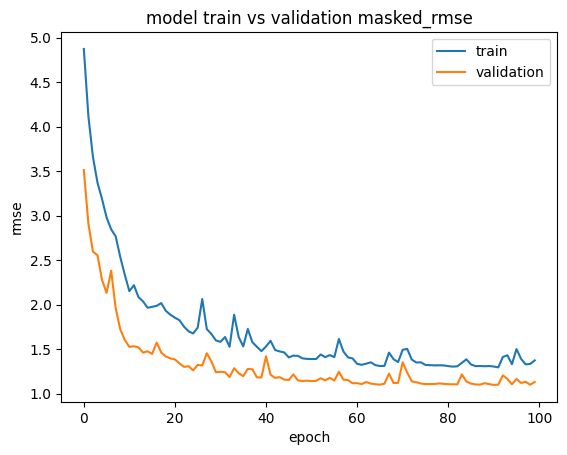

In [ ]:
rmse = hist_Autorec_anime.history['masked_rmse_clip_10']
val_rmse = hist_Autorec_anime.history['val_masked_rmse_clip_10']
plt.plot(np.arange(0, len(rmse), 1), rmse[0:])
plt.plot(np.arange(0, len(val_rmse), 1), val_rmse[0:])
plt.title('model train vs validation masked_rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [ ]:
test_result = anime_model.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
print(test_result)

157/157 [==============================] - 5s 31ms/step - loss: 3.2717 - masked_mse_clip_10: 2.4835 - masked_rmse_clip_10: 1.1179 - masked_se_clip_10: 20.0692
[3.2717459201812744, 2.4835331439971924, 1.1179330348968506, 20.06924057006836]


In [ ]:
activations=['linear','sigmoid','relu']
for outer_activation in activations:
  for inner_activation in activations:
    gc.collect()
    anime_model = AutoRec(users_items_matrix_train_zero, 0.0005, outer_activation, inner_activation)
    anime_model.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_mse_clip_10, masked_rmse_clip_10])
    hist_Autorec_anime = anime_model.fit(x=users_items_matrix_train_avg, y=users_items_matrix_train_zero,
                  epochs=60,
                  batch_size=256,
                  verbose = 1, 
                  validation_data=[users_items_matrix_train_avg, users_items_matrix_validate])
    test_result = anime_model.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
    print("first: ", outer_activation,"sec: ",inner_activation)
    print(test_result)
    gc.collect()

Epoch 1/60
20/20 [==============================] - 12s 556ms/step - loss: 150.1134 - masked_mse_clip_10: 18.8005 - masked_rmse_clip_10: 4.0045 - val_loss: 27.3003 - val_masked_mse_clip_10: 13.2267 - val_masked_rmse_clip_10: 2.9364
Epoch 2/60
20/20 [==============================] - 11s 559ms/step - loss: 18.5256 - masked_mse_clip_10: 9.3956 - masked_rmse_clip_10: 2.8171 - val_loss: 9.0153 - val_masked_mse_clip_10: 5.8683 - val_masked_rmse_clip_10: 1.9033
Epoch 3/60
20/20 [==============================] - 8s 424ms/step - loss: 7.4934 - masked_mse_clip_10: 4.7329 - masked_rmse_clip_10: 1.9950 - val_loss: 4.9103 - val_masked_mse_clip_10: 3.5887 - val_masked_rmse_clip_10: 1.4711
Epoch 4/60
20/20 [==============================] - 10s 496ms/step - loss: 5.1224 - masked_mse_clip_10: 3.3670 - masked_rmse_clip_10: 1.6880 - val_loss: 4.9243 - val_masked_mse_clip_10: 3.4502 - val_masked_rmse_clip_10: 1.4300
Epoch 5/60
20/20 [==============================] - 12s 615ms/step - loss: 9.4597 - mas

Epoch 1/60
20/20 [==============================] - 12s 551ms/step - loss: 53.1803 - masked_mse_clip_10: 50.8125 - masked_rmse_clip_10: 6.8362 - val_loss: 41.4950 - val_masked_mse_clip_10: 40.5414 - val_masked_rmse_clip_10: 5.5179
Epoch 2/60
20/20 [==============================] - 10s 511ms/step - loss: 51.5943 - masked_mse_clip_10: 50.8125 - masked_rmse_clip_10: 6.8362 - val_loss: 41.2845 - val_masked_mse_clip_10: 40.5414 - val_masked_rmse_clip_10: 5.5179
Epoch 3/60
20/20 [==============================] - 11s 569ms/step - loss: 51.4750 - masked_mse_clip_10: 50.8125 - masked_rmse_clip_10: 6.8362 - val_loss: 41.2430 - val_masked_mse_clip_10: 40.5414 - val_masked_rmse_clip_10: 5.5179
Epoch 4/60
20/20 [==============================] - 9s 435ms/step - loss: 51.4443 - masked_mse_clip_10: 50.8125 - masked_rmse_clip_10: 6.8362 - val_loss: 41.2169 - val_masked_mse_clip_10: 40.5414 - val_masked_rmse_clip_10: 5.5179
Epoch 5/60
20/20 [==============================] - 10s 509ms/step - loss: 51

Epoch 1/60
20/20 [==============================] - 11s 539ms/step - loss: 152.5677 - masked_mse_clip_10: 41.4597 - masked_rmse_clip_10: 6.1131 - val_loss: 65.2846 - val_masked_mse_clip_10: 39.3802 - val_masked_rmse_clip_10: 5.4229
Epoch 2/60
20/20 [==============================] - 11s 576ms/step - loss: 88.9117 - masked_mse_clip_10: 49.8747 - masked_rmse_clip_10: 6.7700 - val_loss: 87.0302 - val_masked_mse_clip_10: 40.2354 - val_masked_rmse_clip_10: 5.4924
Epoch 3/60
20/20 [==============================] - 8s 415ms/step - loss: 100.2629 - masked_mse_clip_10: 50.5012 - masked_rmse_clip_10: 6.8136 - val_loss: 60.3179 - val_masked_mse_clip_10: 39.7073 - val_masked_rmse_clip_10: 5.4524
Epoch 4/60
20/20 [==============================] - 9s 458ms/step - loss: 71.8096 - masked_mse_clip_10: 49.9429 - masked_rmse_clip_10: 6.7749 - val_loss: 55.0199 - val_masked_mse_clip_10: 40.1176 - val_masked_rmse_clip_10: 5.4847
Epoch 5/60
20/20 [==============================] - 10s 489ms/step - loss: 6

Epoch 1/60
20/20 [==============================] - 11s 476ms/step - loss: 39.0814 - masked_mse_clip_10: 36.3778 - masked_rmse_clip_10: 5.6959 - val_loss: 13.3658 - val_masked_mse_clip_10: 12.7615 - val_masked_rmse_clip_10: 3.0293
Epoch 2/60
20/20 [==============================] - 13s 643ms/step - loss: 8.3547 - masked_mse_clip_10: 7.7405 - masked_rmse_clip_10: 2.4974 - val_loss: 3.3699 - val_masked_mse_clip_10: 2.6644 - val_masked_rmse_clip_10: 1.2825
Epoch 3/60
20/20 [==============================] - 10s 511ms/step - loss: 3.3008 - masked_mse_clip_10: 2.5778 - masked_rmse_clip_10: 1.4489 - val_loss: 2.8747 - val_masked_mse_clip_10: 2.0910 - val_masked_rmse_clip_10: 1.1233
Epoch 4/60
20/20 [==============================] - 11s 568ms/step - loss: 2.9980 - masked_mse_clip_10: 2.2253 - masked_rmse_clip_10: 1.3582 - val_loss: 2.8375 - val_masked_mse_clip_10: 2.0238 - val_masked_rmse_clip_10: 1.1070
Epoch 5/60
20/20 [==============================] - 9s 433ms/step - loss: 2.9049 - maske

Epoch 1/60
20/20 [==============================] - 13s 608ms/step - loss: 53.7616 - masked_mse_clip_10: 50.8125 - masked_rmse_clip_10: 6.8362 - val_loss: 41.2511 - val_masked_mse_clip_10: 40.5414 - val_masked_rmse_clip_10: 5.5179
Epoch 2/60
20/20 [==============================] - 9s 433ms/step - loss: 51.3700 - masked_mse_clip_10: 50.8125 - masked_rmse_clip_10: 6.8362 - val_loss: 41.0053 - val_masked_mse_clip_10: 40.5414 - val_masked_rmse_clip_10: 5.5179
Epoch 3/60
20/20 [==============================] - 10s 485ms/step - loss: 51.2288 - masked_mse_clip_10: 50.8125 - masked_rmse_clip_10: 6.8362 - val_loss: 40.9373 - val_masked_mse_clip_10: 40.5414 - val_masked_rmse_clip_10: 5.5179
Epoch 4/60
20/20 [==============================] - 10s 487ms/step - loss: 51.1704 - masked_mse_clip_10: 50.8125 - masked_rmse_clip_10: 6.8362 - val_loss: 40.8913 - val_masked_mse_clip_10: 40.5414 - val_masked_rmse_clip_10: 5.5179
Epoch 5/60
20/20 [==============================] - 9s 432ms/step - loss: 51.

Epoch 1/60
20/20 [==============================] - 10s 450ms/step - loss: 46.5220 - masked_mse_clip_10: 39.5171 - masked_rmse_clip_10: 5.9738 - val_loss: 24.1207 - val_masked_mse_clip_10: 20.0875 - val_masked_rmse_clip_10: 3.7395
Epoch 2/60
20/20 [==============================] - 11s 558ms/step - loss: 20.4163 - masked_mse_clip_10: 17.5307 - masked_rmse_clip_10: 3.8883 - val_loss: 8.3138 - val_masked_mse_clip_10: 7.4636 - val_masked_rmse_clip_10: 2.1421
Epoch 3/60
20/20 [==============================] - 12s 613ms/step - loss: 5.2980 - masked_mse_clip_10: 4.6295 - masked_rmse_clip_10: 1.9314 - val_loss: 2.9798 - val_masked_mse_clip_10: 2.3223 - val_masked_rmse_clip_10: 1.1799
Epoch 4/60
20/20 [==============================] - 9s 474ms/step - loss: 2.9320 - masked_mse_clip_10: 2.2769 - masked_rmse_clip_10: 1.3766 - val_loss: 2.7705 - val_masked_mse_clip_10: 2.0715 - val_masked_rmse_clip_10: 1.1248
Epoch 5/60
20/20 [==============================] - 8s 411ms/step - loss: 2.7723 - mask

Epoch 1/60
20/20 [==============================] - 11s 513ms/step - loss: 33.2307 - masked_mse_clip_10: 15.8165 - masked_rmse_clip_10: 3.5461 - val_loss: 4.6274 - val_masked_mse_clip_10: 3.4786 - val_masked_rmse_clip_10: 1.4265
Epoch 2/60
20/20 [==============================] - 10s 506ms/step - loss: 2.6887 - masked_mse_clip_10: 2.0438 - masked_rmse_clip_10: 1.2887 - val_loss: 2.9230 - val_masked_mse_clip_10: 2.2924 - val_masked_rmse_clip_10: 1.1235
Epoch 3/60
20/20 [==============================] - 11s 565ms/step - loss: 2.0949 - masked_mse_clip_10: 1.5624 - masked_rmse_clip_10: 1.1274 - val_loss: 2.6010 - val_masked_mse_clip_10: 1.9686 - val_masked_rmse_clip_10: 1.0075
Epoch 4/60
20/20 [==============================] - 8s 407ms/step - loss: 2.0318 - masked_mse_clip_10: 1.5076 - masked_rmse_clip_10: 1.1049 - val_loss: 2.8790 - val_masked_mse_clip_10: 2.2763 - val_masked_rmse_clip_10: 1.1271
Epoch 5/60
20/20 [==============================] - 9s 480ms/step - loss: 2.0922 - masked_m

Epoch 1/60
20/20 [==============================] - 11s 542ms/step - loss: 52.1393 - masked_mse_clip_10: 50.8125 - masked_rmse_clip_10: 6.8362 - val_loss: 41.0756 - val_masked_mse_clip_10: 40.5414 - val_masked_rmse_clip_10: 5.5179
Epoch 2/60
20/20 [==============================] - 10s 506ms/step - loss: 51.2118 - masked_mse_clip_10: 50.8125 - masked_rmse_clip_10: 6.8362 - val_loss: 40.9506 - val_masked_mse_clip_10: 40.5414 - val_masked_rmse_clip_10: 5.5179
Epoch 3/60
20/20 [==============================] - 9s 460ms/step - loss: 51.1470 - masked_mse_clip_10: 50.8125 - masked_rmse_clip_10: 6.8362 - val_loss: 40.9237 - val_masked_mse_clip_10: 40.5414 - val_masked_rmse_clip_10: 5.5179
Epoch 4/60
20/20 [==============================] - 9s 461ms/step - loss: 51.1204 - masked_mse_clip_10: 50.8125 - masked_rmse_clip_10: 6.8362 - val_loss: 40.9021 - val_masked_mse_clip_10: 40.5414 - val_masked_rmse_clip_10: 5.5179
Epoch 5/60
20/20 [==============================] - 10s 507ms/step - loss: 51.

Epoch 1/60
20/20 [==============================] - 10s 451ms/step - loss: 48.2661 - masked_mse_clip_10: 25.6595 - masked_rmse_clip_10: 4.7388 - val_loss: 20.5407 - val_masked_mse_clip_10: 16.0396 - val_masked_rmse_clip_10: 3.1975
Epoch 2/60
20/20 [==============================] - 10s 503ms/step - loss: 19.7755 - masked_mse_clip_10: 15.4939 - masked_rmse_clip_10: 3.6024 - val_loss: 12.6945 - val_masked_mse_clip_10: 9.8600 - val_masked_rmse_clip_10: 2.3674
Epoch 3/60
20/20 [==============================] - 12s 602ms/step - loss: 15.1416 - masked_mse_clip_10: 11.7901 - masked_rmse_clip_10: 3.1016 - val_loss: 12.1392 - val_masked_mse_clip_10: 9.4273 - val_masked_rmse_clip_10: 2.3003
Epoch 4/60
20/20 [==============================] - 11s 567ms/step - loss: 14.8619 - masked_mse_clip_10: 11.5546 - masked_rmse_clip_10: 3.0610 - val_loss: 12.0837 - val_masked_mse_clip_10: 9.3591 - val_masked_rmse_clip_10: 2.2836
Epoch 5/60
20/20 [==============================] - 8s 431ms/step - loss: 14.85

## I-AutoRec

In [ ]:
def my_proc_2(cont):
  matrix = np.full((max_anime,max_user),0)
  for r in cont:
    matrix[int(r[1])-1,int(r[0])-1] = float(r[2])
  return matrix

def my_proc_avg_2(cont): 
  matrix = np.full((max_anime,max_user),0)
  for r in cont:
    matrix[int(r[1])-1,int(r[0])-1] = float(r[2])
  avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
  inds = np.where(matrix == 0)
  matrix[inds] = np.take(avergae, inds[0])
  return matrix

In [ ]:
train_df, test_df = train_test_split(datContent,test_size=0.1,random_state=999613182)  
train_df, validate_df = train_test_split(train_df,test_size=0.1,random_state=999613182) 
print(len(train_df),len(test_df),len(validate_df))

340153 41995 37795


In [ ]:
users_items_matrix_train_zero = my_proc_2(train_df)
users_items_matrix_train_avg = my_proc_avg_2(train_df)
users_items_matrix_validate = my_proc_2(validate_df)
users_items_matrix_test = my_proc_2(test_df)

In [ ]:
users_items_matrix_train_zero.shape

(7390, 5000)

In [ ]:
model2_anime = AutoRec(users_items_matrix_train_zero, 0.0005, 'elu', 'elu')

model2_anime.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_mse_clip_10, masked_rmse_clip_10,masked_se_clip_10])
 
model2_anime.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 5000)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               2500500   
                                                                 
 UserScorePred (Dense)       (None, 5000)              2505000   
                                                                 
Total params: 5,005,500
Trainable params: 5,005,500
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Autorec2_anime = model2_anime.fit(x=users_items_matrix_train_avg, y=users_items_matrix_train_zero,
                  epochs=100,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_avg, users_items_matrix_validate])

Epoch 1/100
<class 'tensorflow.python.framework.ops.Tensor'>   <class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>   <class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>   <class 'tensorflow.python.framework.ops.Tensor'>
29/29 - 13s - loss: 35.4301 - masked_mse_clip_10: 14.0067 - masked_rmse_clip_10: 3.3497 - masked_se_clip_10: 782.5566 - val_loss: 9.7894 - val_masked_mse_clip_10: 6.3217 - val_masked_rmse_clip_10: 1.6506 - val_masked_se_clip_10: 52.6375 - 13s/epoch - 451ms/step
Epoch 2/100
29/29 - 8s - loss: 12.2934 - masked_mse_clip_10: 7.7052 - masked_rmse_clip_10: 2.3654 - masked_se_clip_10: 362.6059 - val_loss: 7.3722 - val_masked_mse_clip_10: 4.6964 - val_masked_rmse_clip_10: 1.3534 - val_masked_se_clip_10: 34.2473 - 8s/epoch - 266ms/step
Epoch 3/100
29/29 - 8s - loss: 10.1997 - masked_mse_clip_10: 6.3020 - masked_rmse_clip_10: 2.0799 - masked_se_clip_10: 267.4295 - val_loss: 6.6625 - val_ma

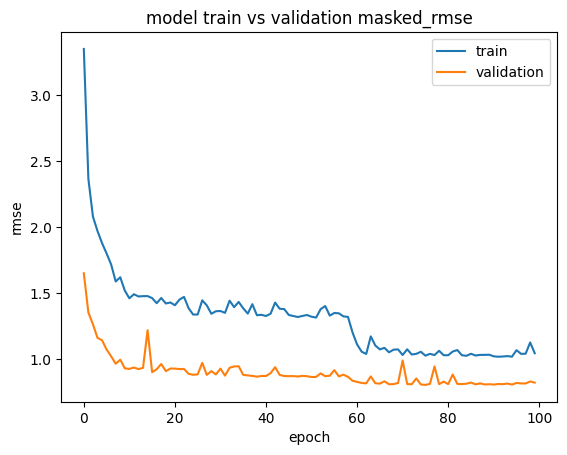

In [ ]:
rmse = hist_Autorec2_anime.history['masked_rmse_clip_10']
val_rmse = hist_Autorec2_anime.history['val_masked_rmse_clip_10']
plt.plot(np.arange(0, len(rmse), 1), rmse[0:])
plt.plot(np.arange(0, len(val_rmse), 1), val_rmse[0:])
plt.title('model train vs validation masked_rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [ ]:
test_result = model2_anime.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
print(test_result)

231/231 [==============================] - 4s 17ms/step - loss: 2.2623 - masked_mse_clip_10: 1.7952 - masked_rmse_clip_10: 0.8297 - masked_se_clip_10: 11.7623
[2.262280225753784, 1.7951539754867554, 0.8297481536865234, 11.762250900268555]


## Deep Autoencoder

In [ ]:
datContent = [i.strip().split() for i in open("book_ratings.dat").readlines()][1:]

In [ ]:
max_user=0
max_book=0
for r in datContent:
  # print(r)
  max_user=max(max_user,int(r[0]))
  max_book=max(max_book,int(r[1]))
print(max_book,max_user)

17384 2945


In [ ]:
train_df, test_df = train_test_split(datContent,test_size=0.1,random_state=999613182)  
train_df, validate_df = train_test_split(train_df,test_size=0.1,random_state=999613182) 
users_items_matrix_train_zero = my_proc(train_df)
users_items_matrix_train_avg = my_proc_avg(train_df)
users_items_matrix_validate = my_proc(validate_df)
users_items_matrix_test = my_proc(test_df)

In [ ]:
 def Deep_AE_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, side_infor_size=0):
    '''
    Build Deep AE for CF
        INPUT: 
            X: #_user X #_item matrix
            layers: List, each element is the number of neuron for a layer
            reg: L2 regularization parameter
            activation: activation function for all dense layer except the last
            last_activation: activation function for the last dense layer
            dropout: dropout rate
            regularizer_encode: regularizer for encoder
            regularizer_decode: regularizer for decoder
            side_infor_size: size of the one hot encoding side information
        OUTPUT:
            Keras model
    '''

    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    
    # Encoder
    # -----------------------------
    k = int(len(layers)/2)
    i = 0
    for l in layers[:k]:
      x = Dense(l, activation=activation,
                      name='EncLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_encode))(x)
      i = i+1
      
      
    # Latent Space
    # -----------------------------
    x = Dense(layers[k], activation=activation, 
                                name='LatentSpace', kernel_regularizer=regularizers.l2(regularizer_encode))(x)
    
    # Dropout
    x = Dropout(rate = dropout)(x)
    
    # Decoder
    # -----------------------------
    for l in layers[k+1:]:
      i = i-1
      x = Dense(l, activation=activation, 
                      name='DecLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_decode))(x)
      
    # Output

    output_layer = Dense(X.shape[1]-side_infor_size, activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model
     

In [ ]:
layers = [256, 512, 256]
#layers = [512, 256, 128, 256, 512]
#layers = [512, 256, 512]
#layers = [128, 256, 512, 256, 128]
#layers = [512, 512, 512]
dropout = 0.8
# activation = 'sigmoid'
# last_activation = 'linear'
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [ ]:
Deep_AE = Deep_AE_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE.summary()

In [ ]:
hist_Deep_AE = Deep_AE.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=100,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate], verbose=2)

Epoch 1/100
12/12 - 13s - loss: 30.2253 - masked_rmse_clip: 3.1124 - val_loss: 27.2416 - val_masked_rmse_clip: 2.8862 - 13s/epoch - 1s/step
Epoch 2/100
12/12 - 12s - loss: 22.4547 - masked_rmse_clip: 2.8399 - val_loss: 12.0108 - val_masked_rmse_clip: 1.8007 - 12s/epoch - 991ms/step
Epoch 3/100
12/12 - 9s - loss: 8.1648 - masked_rmse_clip: 1.6691 - val_loss: 7.6539 - val_masked_rmse_clip: 1.6250 - 9s/epoch - 728ms/step
Epoch 4/100
12/12 - 9s - loss: 4.4644 - masked_rmse_clip: 1.5149 - val_loss: 5.6070 - val_masked_rmse_clip: 1.5148 - 9s/epoch - 737ms/step
Epoch 5/100
12/12 - 9s - loss: 3.2745 - masked_rmse_clip: 1.4729 - val_loss: 5.5209 - val_masked_rmse_clip: 1.5184 - 9s/epoch - 719ms/step
Epoch 6/100
12/12 - 7s - loss: 3.0402 - masked_rmse_clip: 1.4658 - val_loss: 5.3830 - val_masked_rmse_clip: 1.5172 - 7s/epoch - 619ms/step
Epoch 7/100
12/12 - 8s - loss: 2.8010 - masked_rmse_clip: 1.4619 - val_loss: 5.2214 - val_masked_rmse_clip: 1.5130 - 8s/epoch - 692ms/step
Epoch 8/100
12/12 - 10

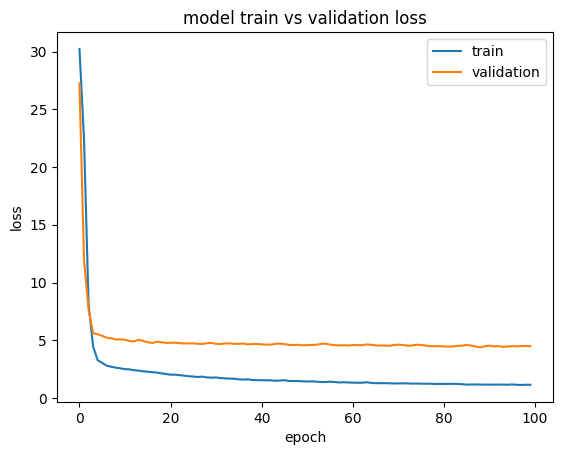

In [ ]:
show_error(hist_Deep_AE,0)